# Behavioural Segmentation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
import warnings
warnings.filterwarnings('ignore')

#### Datasets

In [3]:
inc_df=pd.read_csv("./Collected Data/Indian Age and Income Data/age_income.csv")

In [4]:
inc_df.head()

,Age,Profession,Marrital Status,Education,No of Dependents,Personal loan,Total Salary,Price
0,27,Salaried,Single,Post Graduate,0,Yes,800000,800000
1,35,Salaried,Married,Post Graduate,2,Yes,2000000,1000000
2,45,Business,Married,Graduate,4,Yes,1800000,1200000
3,41,Business,Married,Post Graduate,3,No,2200000,1200000
4,31,Salaried,Married,Post Graduate,2,Yes,2600000,1600000


In [5]:
inc_df.isnull().sum()

Age                 0
Profession          0
Marrital Status     0
Education           0
No of Dependents    0
Personal loan       0
Total Salary        0
Price               0
dtype: int64

In [6]:
inc_df.rename(columns={'Personal loan':'Car_Loan'},inplace=True)
inc_df.rename(columns={'Price':'EV_Price'},inplace=True)
inc_df.head()

,Age,Profession,Marrital Status,Education,No of Dependents,Car_Loan,Total Salary,EV_Price
0,27,Salaried,Single,Post Graduate,0,Yes,800000,800000
1,35,Salaried,Married,Post Graduate,2,Yes,2000000,1000000
2,45,Business,Married,Graduate,4,Yes,1800000,1200000
3,41,Business,Married,Post Graduate,3,No,2200000,1200000
4,31,Salaried,Married,Post Graduate,2,Yes,2600000,1600000


### EDA

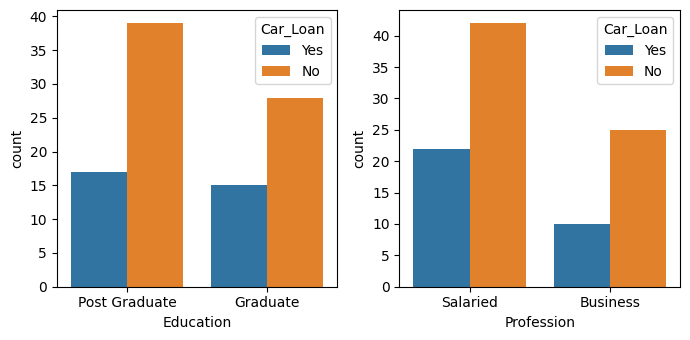

In [7]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 2)
sns.countplot(x ='Education', hue = 'Car_Loan',  data = inc_df, ax=axes[0])
sns.countplot(x ='Profession', hue = 'Car_Loan',  data = inc_df, ax=axes[1])
plt.show()

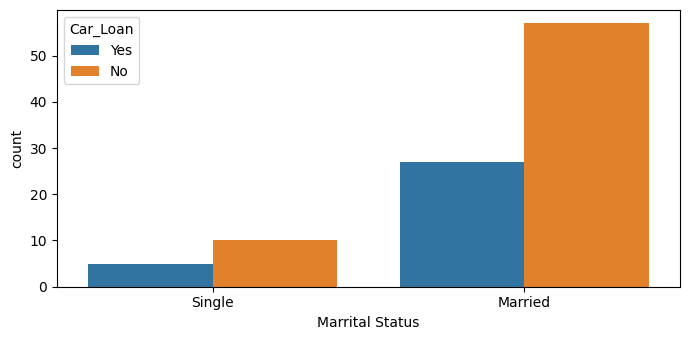

In [8]:
sns.countplot(x ='Marrital Status', hue = 'Car_Loan',  data = inc_df)
plt.show()

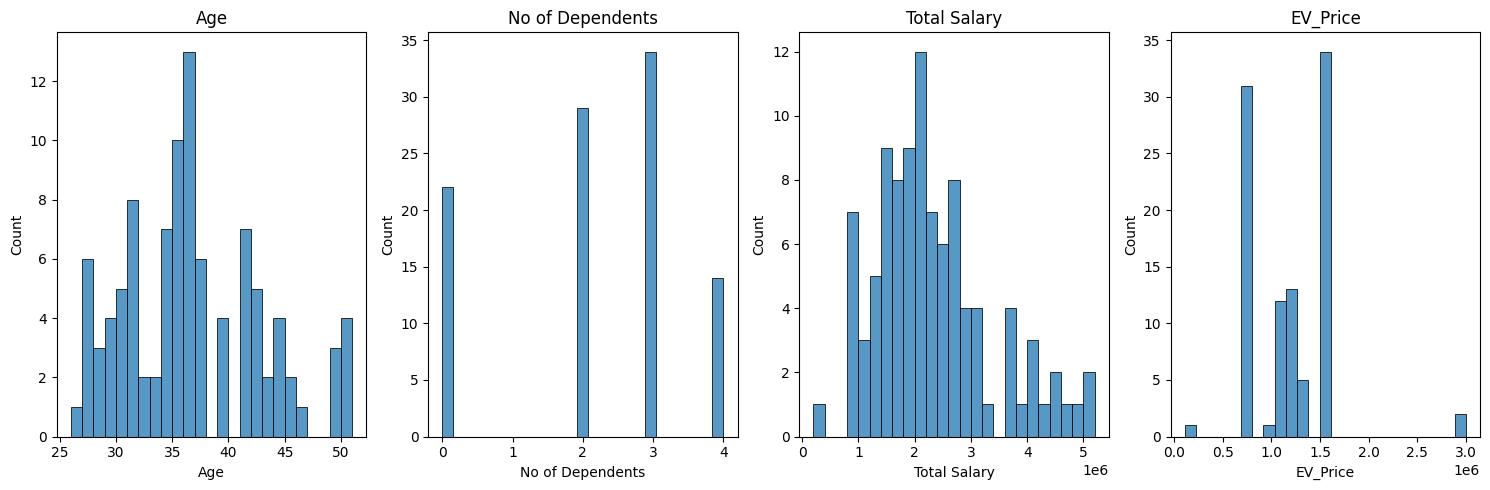

In [9]:
plt.figure(1, figsize=(15,5))
n=0

for x in ['Age', 'No of Dependents' ,'Total Salary'  ,'EV_Price']:
  n += 1
  plt.subplot(1,4,n)
  plt.subplots_adjust(hspace=0.5, wspace=0.5)
  sns.histplot(inc_df[x], bins= 25)
  plt.title(f'{x}')
plt.show()

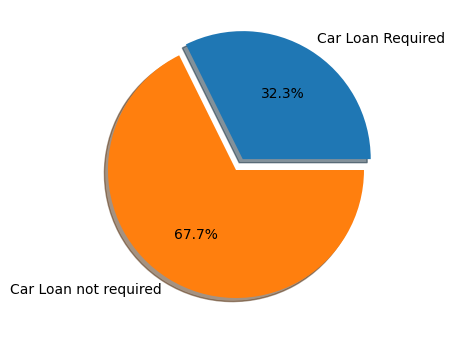

In [10]:
labels = ['Car Loan Required','Car Loan not required']
Loan_status = [inc_df.query('Car_Loan == "Yes"').Car_Loan.count(),inc_df.query('Car_Loan == "No"').Car_Loan.count()]

explode = [0.1, 0]
plt.pie(Loan_status, labels=labels, shadow = "True",
        explode=explode, autopct='%1.1f%%')
  
plt.show()

In [11]:
inc_df['Profession'].value_counts()

Profession
Salaried    64
Business    35
Name: count, dtype: int64

In [12]:
inc_df['Marrital Status'].value_counts()

Marrital Status
Married    84
Single     15
Name: count, dtype: int64

In [13]:
inc_df['Education'].value_counts()

Education
Post Graduate    56
Graduate         43
Name: count, dtype: int64

In [14]:
inc_df['Car_Loan'].value_counts()

Car_Loan
No     67
Yes    32
Name: count, dtype: int64

In [15]:
inc_df['Marrital Status'].replace({'Single':0,'Married':1},inplace=True)
inc_df['Car_Loan'].replace({'No':0,'Yes':1},inplace=True)
inc_df['Education'].replace({'Graduate':0,'Post Graduate':1},inplace=True)
inc_df['Profession'].replace({'Salaried':0, 'Business':1},inplace=True)

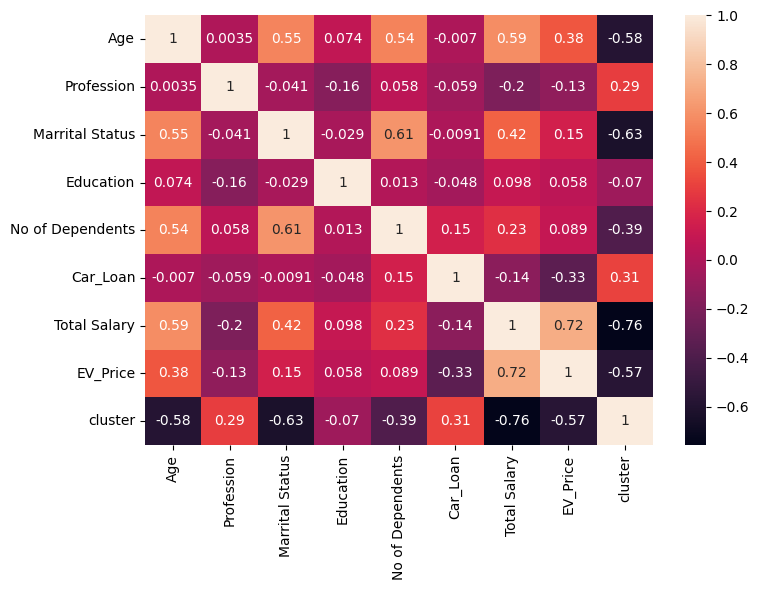

In [37]:
correlation_matrix = inc_df.corr()

# Create the heatmap
plt.figure(figsize = (8,6))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

#### PCA and Clustering

In [17]:
# corellation present, hence PCA
X = inc_df
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X.shape

(99, 8)

In [18]:
pca = PCA()    #creating the instance of class PCA
pca.fit_transform(X_scaled) 
pca.explained_variance_ratio_

array([0.34653101, 0.1920909 , 0.14332375, 0.11282393, 0.08822937,
       0.04894954, 0.04512684, 0.02292466])

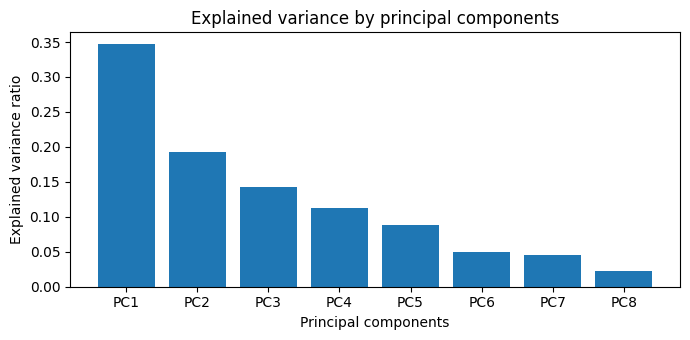

In [19]:
components=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']
var_exp = pca.explained_variance_ratio_
plt.bar(components, var_exp)
plt.title('Explained variance by principal components')
plt.xlabel('Principal components')
plt.ylabel('Explained variance ratio')
plt.show()

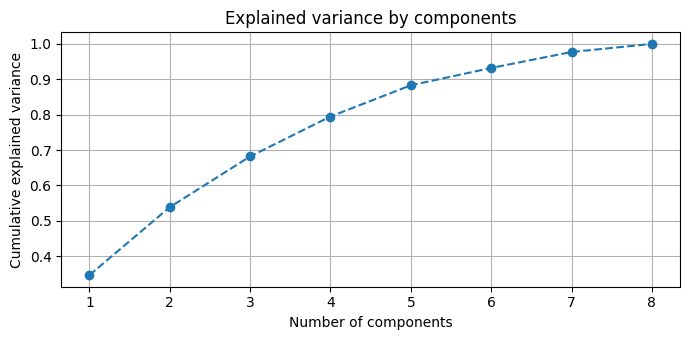

In [20]:
plt.plot(range(1,9),pca.explained_variance_ratio_.cumsum(),marker='o', linestyle='--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()

In [21]:
#only taking 5 components
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
df_pca.head()

,PC1,PC2,PC3,PC4,PC5
0,-3.456779,-0.618798,-1.775729,-0.151357,1.047749
1,-0.274146,0.658946,-1.695786,-0.042108,0.291098
2,0.879912,2.388637,0.925667,-0.363319,1.116538
3,0.771649,0.376038,0.757106,1.685393,0.163439
4,0.219923,-0.252808,-1.513077,-0.399144,0.710610


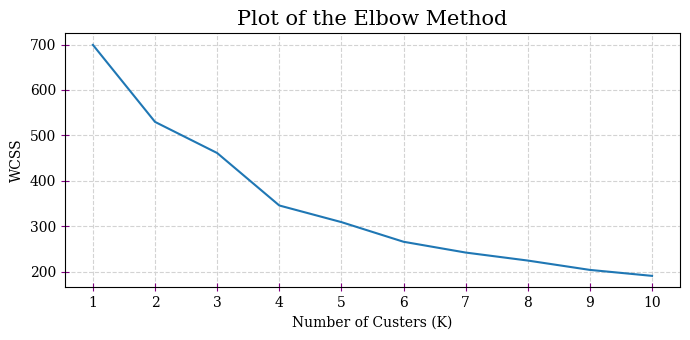

In [22]:
wcss = []

for i in range(1, 11):
  kmean = KMeans(n_clusters=i, init='k-means++', random_state=90)
  kmean.fit(X_pca)
  wcss.append(kmean.inertia_)

plt.title('Plot of the Elbow Method', size=15, family='serif')
plt.plot(range(1, 11), wcss)
plt.xticks(range(1, 11), family='serif')
plt.yticks(family='serif')
plt.xlabel('Number of Custers (K)', family='serif')
plt.ylabel('WCSS', family='serif')
plt.grid()
plt.tick_params(axis='both', direction='inout', length=6, color='purple', grid_color='lightgray', grid_linestyle='--')
plt.show()

In [23]:
kmean = KMeans(n_clusters=4, init='k-means++', random_state=90)
kmean.fit(X_pca)

KMeans(n_clusters=4, random_state=90)

In [24]:
print(kmean.labels_)

[3 2 2 2 2 2 1 2 2 2 1 2 3 3 2 0 3 3 3 1 1 2 1 2 2 1 2 2 2 1 2 1 0 1 2 0 3
 1 3 1 2 3 1 1 2 1 2 1 1 2 2 0 0 0 0 0 1 3 3 3 3 3 3 2 1 2 2 1 0 1 1 0 1 1
 1 0 2 1 0 0 2 0 2 0 2 2 3 1 1 2 1 0 1 3 3 0 2 0 2]


In [25]:
pd.Series(kmean.labels_).value_counts()

2    34
1    29
3    18
0    18
Name: count, dtype: int64

In [26]:
inc_df['cluster'] = kmean.labels_
inc_df.head()

,Age,Profession,Marrital Status,Education,No of Dependents,Car_Loan,Total Salary,EV_Price,cluster
0,27,0,0,1,0,1,800000,800000,3
1,35,0,1,1,2,1,2000000,1000000,2
2,45,1,1,0,4,1,1800000,1200000,2
3,41,1,1,1,3,0,2200000,1200000,2
4,31,0,1,1,2,1,2600000,1600000,2


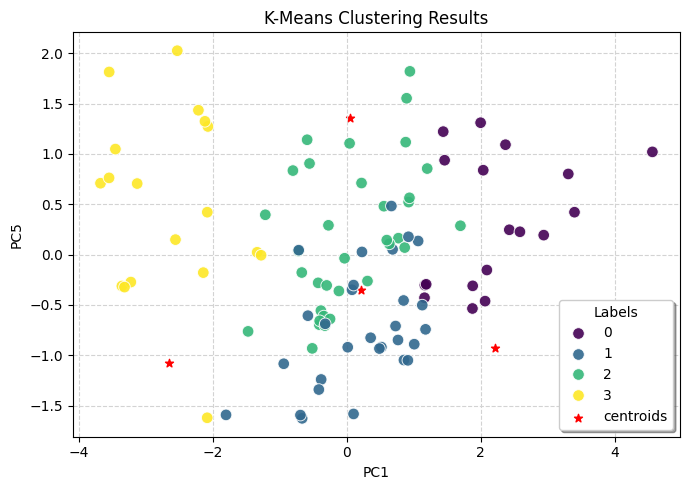

In [27]:
#forming clusters can be seen through a 2-D plot of the Principal components having clusters
plt.figure(figsize=(7,5))
sns.scatterplot(data=df_pca, x='PC1', y='PC5', s=70, hue=kmean.labels_, palette='viridis', zorder=2, alpha=.9)
plt.scatter(x=kmean.cluster_centers_[:,0], y=kmean.cluster_centers_[:,1], marker="*", c="r", label="centroids")
plt.xlabel('PC1')
plt.ylabel('PC5')
plt.grid(True)
plt.tick_params(grid_color='lightgray', grid_linestyle='--')
plt.legend(title='Labels', shadow=True)
plt.title('K-Means Clustering Results')
plt.show()

In [28]:
rotations = pca.components_.T

rotations_df = pd.DataFrame(rotations, columns=[f'PC{i+1}' for i in range(rotations.shape[1])], index=inc_df.columns[:8])

rotations_df = rotations_df.round(1)

std_devs = np.sqrt(pca.explained_variance_).round(1)

print("Standard deviations:")
print(std_devs)
print("Rotation matrix:")
print(rotations_df)

Standard deviations:
[1.7 1.2 1.1 1.  0.8]
Rotation matrix:
                  PC1  PC2  PC3  PC4  PC5
Age               0.5  0.1  0.0  0.1  0.2
Profession       -0.1  0.3  0.7  0.4  0.5
Marrital Status   0.4  0.3  0.0  0.0 -0.4
Education         0.1 -0.2 -0.6  0.8  0.1
No of Dependents  0.4  0.5 -0.0  0.2 -0.2
Car_Loan         -0.1  0.5 -0.4 -0.3  0.6
Total Salary      0.5 -0.3 -0.0 -0.2  0.3
EV_Price          0.4 -0.5  0.2 -0.1  0.3


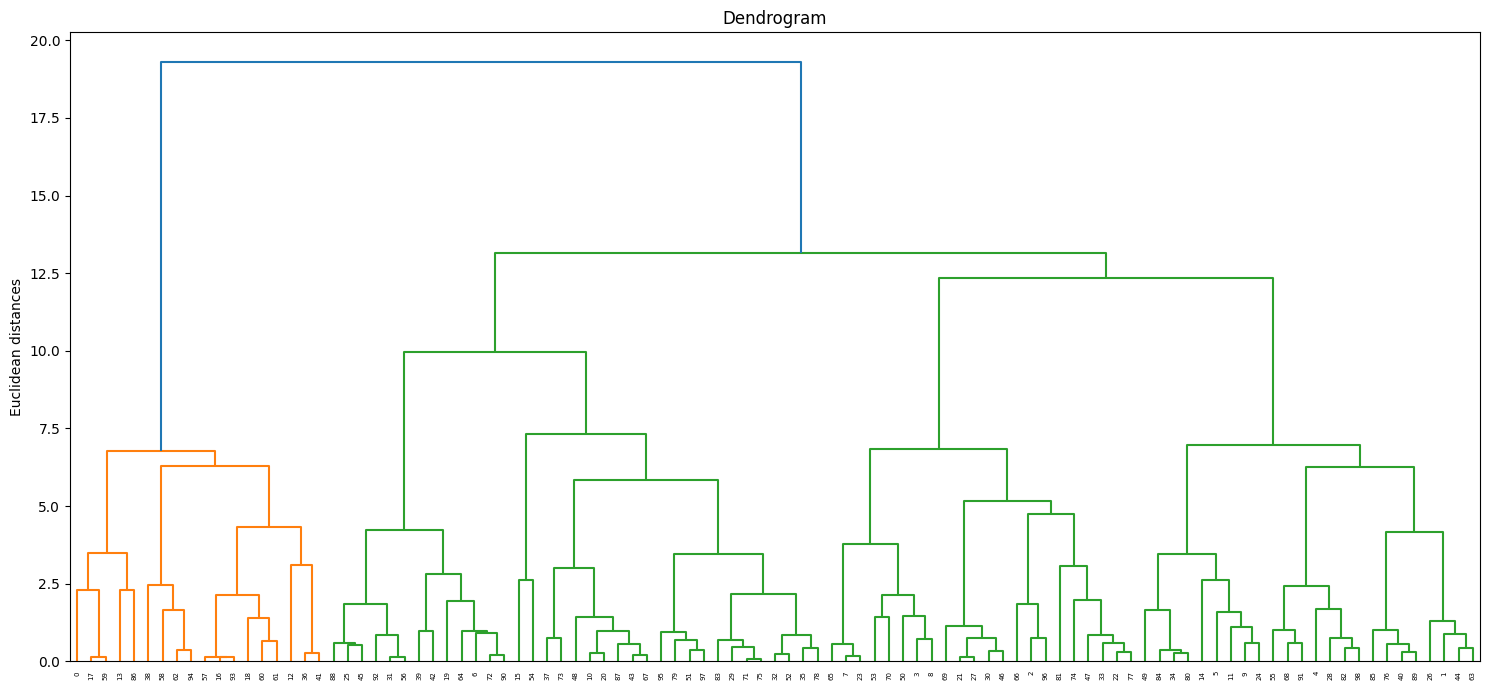

In [29]:
plt.figure(figsize=(15,7))
dendrogram = sch.dendrogram(sch.linkage(df_pca, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('')
plt.ylabel('Euclidean distances')
plt.show()

### Making Predictions

In [30]:
inc_df["cluster"].value_counts()

cluster
2    34
1    29
3    18
0    18
Name: count, dtype: int64

In [31]:
Cluster_0=inc_df[inc_df.cluster==0]
Cluster_1=inc_df[inc_df.cluster==1]
Cluster_2=inc_df[inc_df.cluster==2]
Cluster_3=inc_df[inc_df.cluster==3]

In [32]:
[Cluster_0["Age"].value_counts().head(),
Cluster_1["Age"].value_counts().head(),
Cluster_2["Age"].value_counts().head(),
Cluster_3["Age"].value_counts().head()]
# target 27-30 years

[Age
 44    4
 41    3
 49    2
 42    2
 36    2
 Name: count, dtype: int64,
 Age
 36    6
 37    5
 35    4
 31    3
 34    3
 Name: count, dtype: int64,
 Age
 35    6
 36    5
 31    4
 34    4
 42    3
 Name: count, dtype: int64,
 Age
 27    6
 29    4
 30    3
 28    2
 26    1
 Name: count, dtype: int64]

In [33]:
[Cluster_0["Total Salary"].value_counts().head(),
Cluster_1["Total Salary"].value_counts().head(),
Cluster_2["Total Salary"].value_counts().head(),
Cluster_3["Total Salary"].value_counts().head()]
# target 16-20 lpa

[Total Salary
 4500000    2
 3100000    2
 4000000    2
 3000000    1
 3700000    1
 Name: count, dtype: int64,
 Total Salary
 2100000    3
 2200000    3
 1300000    2
 2500000    2
 2400000    2
 Name: count, dtype: int64,
 Total Salary
 2000000    4
 1900000    4
 1400000    3
 1800000    3
 1600000    3
 Name: count, dtype: int64,
 Total Salary
 1400000    4
 800000     3
 900000     3
 1100000    2
 1700000    1
 Name: count, dtype: int64]

In [34]:
[Cluster_0["Profession"].value_counts().head(),
Cluster_1["Profession"].value_counts().head(),
Cluster_2["Profession"].value_counts().head(),
Cluster_3["Profession"].value_counts().head()]
#0-> salaried

[Profession
 0    16
 1     2
 Name: count, dtype: int64,
 Profession
 0    22
 1     7
 Name: count, dtype: int64,
 Profession
 1    18
 0    16
 Name: count, dtype: int64,
 Profession
 0    10
 1     8
 Name: count, dtype: int64]

In [35]:
[Cluster_0["Education"].value_counts().head(),
Cluster_1["Education"].value_counts().head(),
Cluster_2["Education"].value_counts().head(),
Cluster_3["Education"].value_counts().head()]
#post graduate

[Education
 1    16
 0     2
 Name: count, dtype: int64,
 Education
 0    19
 1    10
 Name: count, dtype: int64,
 Education
 1    18
 0    16
 Name: count, dtype: int64,
 Education
 1    12
 0     6
 Name: count, dtype: int64]

In [38]:
[Cluster_0["Car_Loan"].value_counts().head(),
Cluster_1["Car_Loan"].value_counts().head(),
Cluster_2["Car_Loan"].value_counts().head(),
Cluster_3["Car_Loan"].value_counts().head()]

[Car_Loan
 0    15
 1     3
 Name: count, dtype: int64,
 Car_Loan
 0    29
 Name: count, dtype: int64,
 Car_Loan
 1    24
 0    10
 Name: count, dtype: int64,
 Car_Loan
 0    13
 1     5
 Name: count, dtype: int64]